# Important note
Folium maps won't show on display. You can either open them by running insides saved in folder `maps` using Internet Browser or run the notebook manually.

You can also see a sample image corresponding to map's name in folder `previews`.

# Table of content
1. Data check
    - Read `hotels data`
2. Distribution of number of hotels belonging to individal hosts
3. Hosts gender statistics
4. Hotels distribution over districts
    - Read `districts' bondaries data`
    - Assign hotels to districts and count
    - Create maps `m1` and `m2`
4. Distribution of locations of hotels belonging to individual hosts
    - Create map `m3` **(interactive sliders)**
5. Price distribution over districts
    - Price boxplot for each district
    - Create map `m4`
    - Create map `m5` **(interative sliders)**

In [87]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

Download data from `kaggle` under the link: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

It's data from AirBnB including mostly recent (as for december 2019) informations and metrics about hotels located in New York City.

In [88]:
df = pd.read_csv('input/AB_NYC_2019.csv')

# 1. Data check

In [89]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [90]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [91]:
df.shape

(48895, 16)

In [92]:
df.dropna().shape

(38821, 16)

**Comment:**

Around 20% of all rows have at least one missing value (NaNs).

# 2. Distribution of number of hotels belonging to individal hosts
How many hosts own 1 property, how many own 2 properties, ..., how many own 10 properties, ...?

Text(0, 0.5, 'frequency (how many hosts own exact number of properties)')

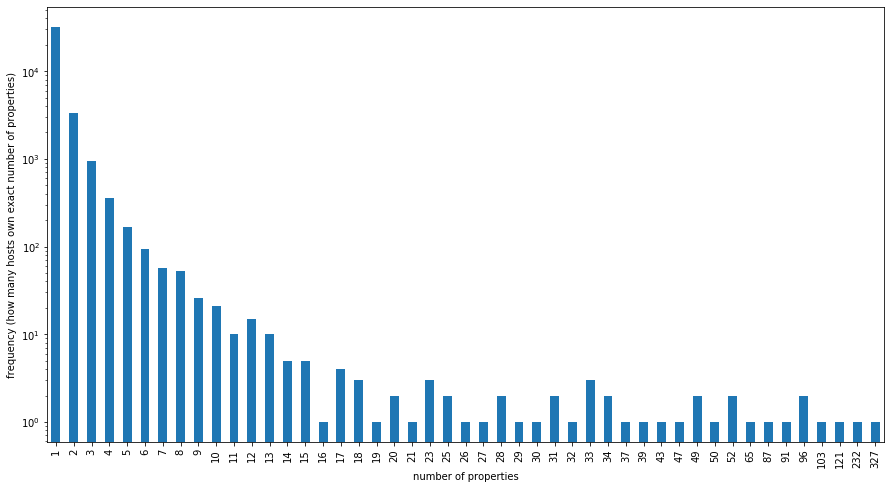

In [93]:
s = df['host_id'].value_counts().value_counts().sort_index()
s.plot(kind = 'bar', logy=True, figsize=(15,8))
plt.xlabel('number of properties')
plt.ylabel('frequency (how many hosts own exact number of properties)')

**Comment:**

Over `32000` people own a single hotel, which is `66%` of all hotels (registered in `AirBnB`) in New York City. Amount of people owning 2 hotels is 10 times less and equal to `6%` of all hotels. There is one person or apparently a company called `Sonder` which owns `327` hotels registered under single ID.

# 3. Hosts gender statistics
Gender statistics over host names

In [94]:
import nltk
from nltk.corpus import names

In [95]:
male_names = set(names.words('male.txt'))
female_names = set(names.words('female.txt'))

In [96]:
print(len(male_names), len(female_names))

2943 5001


In [97]:
df.shape

(48895, 16)

Notice: a "both name" is a name like i.e. "Alex", which can belong to both genders

In [98]:
male_count = 0
female_count = 0
both_count = 0
non_identified_count = 0
n = len(df['host_name'])

for name in df['host_name']:
    if name in male_names  and name not in female_names:
        male_count += 1
    elif name in female_names and name not in male_names:
        female_count += 1
    elif name in male_names and name in female_names:
        both_count += 1
    else:
        non_identified_count += 1
        
print("Male names: {}%\nFemale names: {}%\nBoth names: {}%\nNon_identified: {}%\n".format(
        round(male_count*100/n,1),
        round(female_count*100/n,1),
        round(both_count*100/n,1),
        round(non_identified_count*100/n,1)))

Male names: 25.8%
Female names: 31.0%
Both names: 10.4%
Non_identified: 32.8%



**Comment:**

It's hard to tell whether most hotels belong to men or women as 32.8% of all names couldn't be identified by algorithm.

# 4. Hotels distribution over districts
Count number of hotels per $km^2$ in every district

In [99]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from shapely.geometry import Point
from collections import Counter

In [100]:
# Function for displaying the map
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

## 4.1. Read districts' bondaries data
Download map of `Municipal Court Districts (Clipped to Shoreline)` from page https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page as it divides area of New York in many more districts than standard `Neighborhoods` partition.

In [101]:
geo = gpd.read_file("input/nymc_19d/nymc.shp").to_crs({'init': 'epsg:4326'})

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Insert a column containing shape areas in $km^2$ units

In [102]:
if 'Area in km^2' in geo:
    geo = geo.drop(['Area in km^2'], axis=1)
geo.insert(5, 'Area in km^2', geo['Shape_Area'] * 9.290304e-8)  # convert ft^2 to km^2

## 4.2. Assign hotels to districts and count
How many hotels are in each district?

Create a list containing Point() structures from geographic locations of hotels

In [103]:
points = [Point(df['longitude'].iloc[i], df['latitude'].iloc[i]) for i in range(df.shape[0])]

Check to which district each hotel belongs **(below code takes about a minute to compute)**

In [104]:
district_ID = np.full(len(points), -1) # assign `-1` as an integer nan

for i, point in enumerate(points):
    for j, polygon in enumerate(geo['geometry']):
        if polygon.contains(point):
            district_ID[i] = j

Insert a column to `hotel` dataframe (called `df`) that indicates in which district a certain hotel lies

In [105]:
if 'District_ID' in df:
    df = df.drop(['District_ID'], axis=1)
df.insert(5, 'District_ID', district_ID)

Insert a column to `district` dataframe (called `geo`) which says how many hotels are in certain district

In [106]:
if 'Number of hotels' in geo:
    geo = geo.drop(['Number of hotels'], axis=1)
geo.insert(6, 'Number of hotels', df['District_ID'].value_counts().sort_index()[1:])

Calculate values indicating number of hotels per km^2 in all `districts`

In [107]:
if 'Hotel Density' in geo:
    geo = geo.drop(['Hotel Density'], axis=1)
geo.insert(7, 'Hotel Density', (geo['Number of hotels'] / geo['Area in km^2']))

## 4.3. Create maps `m1` and `m2`
Create a choropleth map of hotel density

In [108]:
# Colors. Note: in frame 'geo' indexes are strings
plot_dict = (geo['Hotel Density'])
plot_dict.index = [str(i) for i in range(0,28)]

# Create a base map
m_1 = folium.Map(location=[40.7,-73.8], tiles='cartodbpositron', zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=geo.__geo_interface__, 
           data=plot_dict,
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='number of hotels / km^2',
           bins = [2,30,100,200,400,600,828]
          ).add_to(m_1)

# Display the map
embed_map(m_1, 'maps/m_1.html')

Create a heatmap of hotels

In [109]:
# Create a base map
m_2 = folium.Map(location=[40.7,-73.8], tiles='cartodbpositron', zoom_start=10)

# Convert to Numpy array!
part_data = df[['latitude','longitude']]
part_data = np.array(part_data)

# Add a heatmap to the base map
HeatMap(data=part_data, radius=10).add_to(m_2)

# Display the map
embed_map(m_2, 'maps/m_2.html')

**Comment:**

Most cluttered parts of New York in terms of hotels are Manhattan and Brooklyn. Other areas have even 30 times lower density of hotels.

# 5. Distribution of locations of hotels belonging to individual hosts
Investigate locations of hotels belonging to an individual `host`.

The host with hightest amount of hotels is "`Sonder`"

In [110]:
from IPython.display import display
from ipywidgets import interact, IntSlider, IntRangeSlider, Button, VBox, Tab
from matplotlib import style

## 5.1. Create map `m3`
Create an interactive plot with an interactive slider. Choose an appriopate `ID` to visualise hotels belonging to `ID`-th biggest owner. Please be carefull that moving sliders very fast can make map not reload.

In [111]:
@interact(ID = IntSlider(1,1,12,1))
def host_hotels(ID):
    
    host_id = df['host_id'].value_counts().index[ID-1]
    host = df[df['host_id'] == host_id]
    amount = df['host_id'].value_counts().iloc[ID-1]
    name = df['host_name'].loc[df['host_id'] == host_id].iloc[0]
    print("Currently displaying {} hotels owned by {}".format(amount, name))
    

    # Create a base map
    m_3 = folium.Map(location=[40.735,-74.0], tiles='cartodbpositron', zoom_start=13)

    # Convert to Numpy array! Or else it will crash
    part_data = host[['latitude','longitude']]
    part_data = np.array(part_data)

    # Add a heatmap to the base map
    HeatMap(data=part_data, radius=10).add_to(m_3)

    # Display the map
    display(embed_map(m_3, 'maps/m_3.html'))

interactive(children=(IntSlider(value=1, description='ID', max=12, min=1), Output()), _dom_classes=('widget-in…

**Comment:**

We see that almost all of `Sonder's` apartaments (both `Sonder (NYC)` and `Sonder`) are located pretty dense, within 2 streets, at the south part of `Manhattan`.

`Blueground` owns hotels on equaly spaced space in `Manhattan`.

Basically, all (except `Ken`) biggest hotel owners have their hotels located in `Manhattan`, as it's clearly the most profitable choice.

# 6. Price distribution over districts
Check distribution of prices amoung districts

## 6.1. Price boxplot for each district
boxplots indicate 25%, 50% and 75% quartiles

Text(0, 0.5, 'price [$] / day')

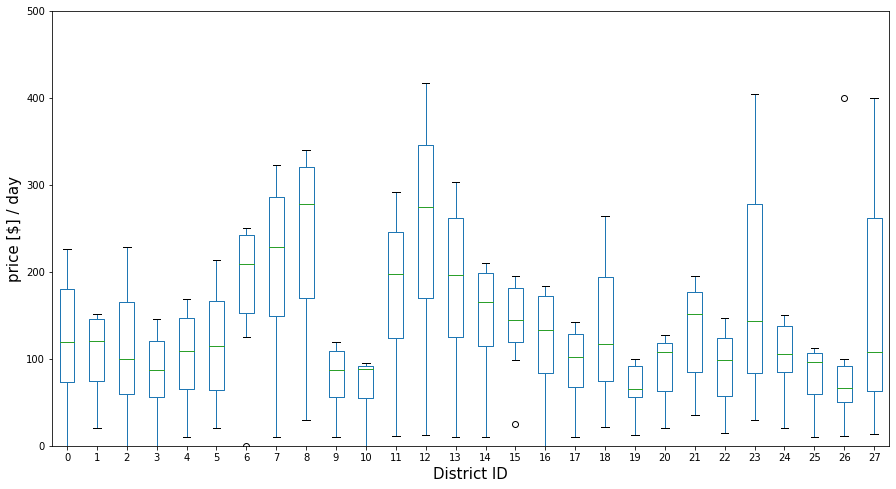

In [112]:
df.groupby('District_ID')['price'].describe().drop(['count'], axis=1).drop(-1).T.plot.box(figsize=(15,8))
plt.ylim(0,500)
plt.xlabel('District ID', size=15)
plt.ylabel('price [$] / day', size=15)

## 6.2. Create map `m4` 
Visualise median prices for all districts on an interactive map.

Popup labels indicate `District ID`.

In [113]:
# Colors. Note: in frame 'geo' indexes are strings
plot_dict = df.groupby('District_ID')['price'].describe().drop(-1)['50%']
plot_dict.index = [str(i) for i in range(0,28)]

# Create a base map
m_4 = folium.Map(location=[40.7,-73.9], tiles='cartodbpositron', zoom_start=11)

# Add markers with labels of `District ID` to the map
for i, point in enumerate(geo['geometry'].centroid):
    Marker([point.y, point.x], popup=(i)).add_to(m_4)

# Add a choropleth map to the base map
Choropleth(geo_data=geo.__geo_interface__, 
           data=plot_dict,
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='median price [$] / day',
          ).add_to(m_4)

# Display the map
embed_map(m_4, 'maps/m_4.html')

**Comment:**

Areas around `Washington Square Park` have much highter median price than most of New York regions, what is quite understable. Noticably, area near Atlantic Beach (`District ID` = 21) is a bit more expensive than surrounding regions. Comparing the map with upper boxplot we can tell, that one of the cheapest hotels are in Bronx side (`District ID` $\in$ {9,10}), which is the most upper part of New York.

## 6.3. Create map `m5` (interactive sliders)
Create an interactive plot with interactive sliders to manually choose price range. To filter prices up to 10000$, change `multiplier` slider to value `20`. Please be carefull that moving sliders very fast can make map not reload.

In [114]:
@interact(price_range = IntRangeSlider(value=[50,500],min=0,max=500), multiplier=IntSlider(20,1,20,1))
def visualise_price(price_range, multiplier):

    price_range = np.array(price_range) * multiplier
    print("Currently displaying hotels with price range from {}$ to {}$".format(price_range[0], price_range[1]))
    
    # Filter values
    test = df[(price_range[0] < df['price']) & (df['price'] < price_range[1])]
    
    # Create a base map
    m_5 = folium.Map(location=[40.7,-73.9], tiles='cartodbpositron', zoom_start=10)

    # Convert to Numpy array
    part_data = test[['latitude','longitude']]
    part_data = np.array(part_data)

    # Add a heatmap to the base map
    HeatMap(data=part_data, radius=10).add_to(m_5)

    # Display the map
    display(embed_map(m_5, 'maps/m_5.html'))

interactive(children=(IntRangeSlider(value=(50, 500), description='price_range', max=500), IntSlider(value=20,…

**Comment:**

We see that south part of Manhatan, around Washington Square Park has the hightest density of hotels with prizes over 1000$ per day.